In [1]:
#%pip install jupyter

In [2]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [3]:
import os
from tramdag import TramDagModel, TramDagConfig

In [4]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp/', experiment_name='dumm1') # works also without arguments, then default paths are used

Configuration already exists: exp/configuration.json


In [5]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'continous', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp/configuration.

/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


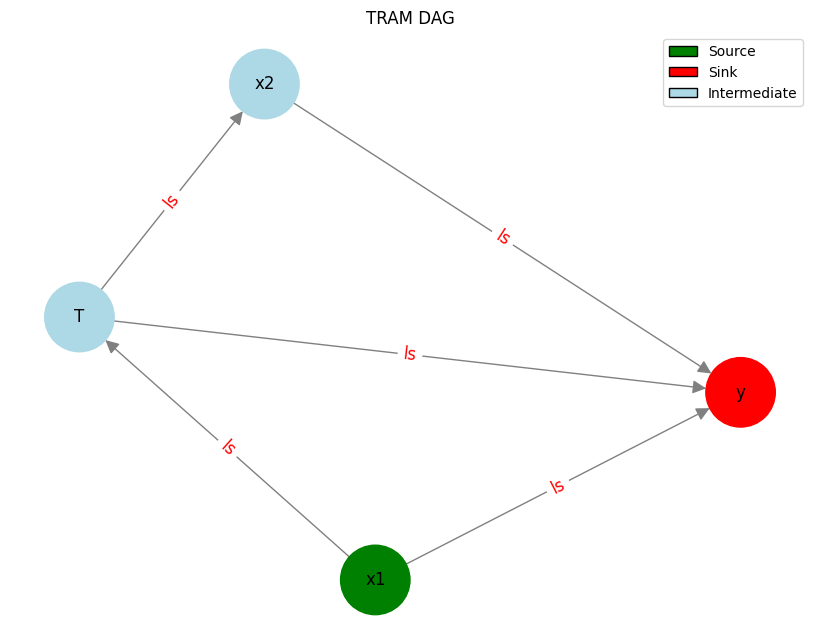

In [6]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

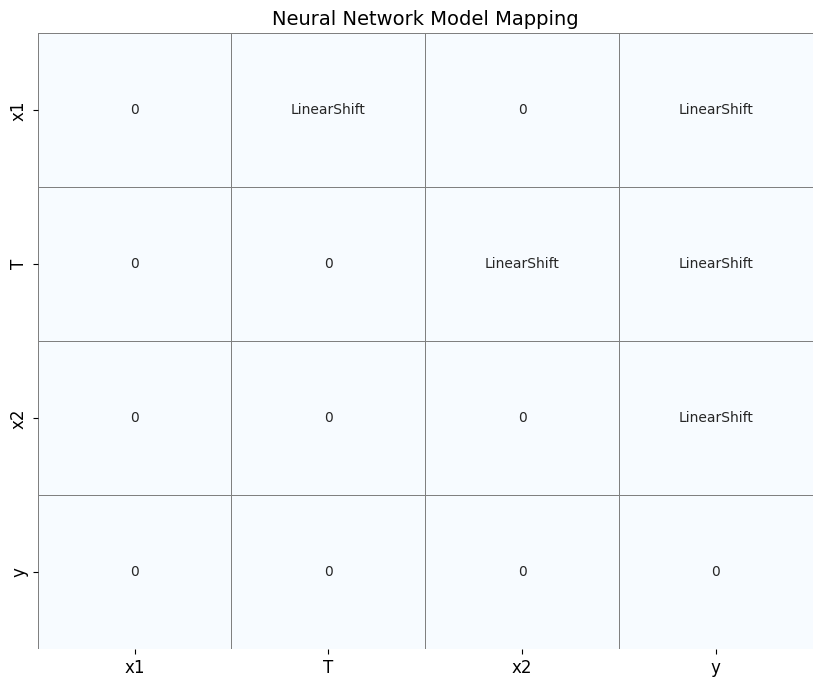

In [7]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [8]:
cfg = TramDagConfig.load_json('exp/configuration.json')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np


# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 1000    
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.044588  1 -1.033152  2.004077
1  1.571853  1 -1.109697  6.659150
2  0.360787  0 -0.128656  0.874634
3  0.352011  0  0.058999  1.197356
4  0.665996  1 -1.015924  4.015427


In [10]:
from tramdag import TramDagModel
#cfg.compute_levels(train_df) #Calculate the levels from the training file


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [11]:
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device)
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

In [13]:
epochs = 100
td_model.fit(train_df, val_df,
             # train_list=['target'], #Training only on a subset of the model
             learning_rate=1e-2,
             epochs=epochs,batch_size=1000,
             verbose=False,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,       #For DataLoader
             train_mode = "sequential") #Parallel is better for many nodes


/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


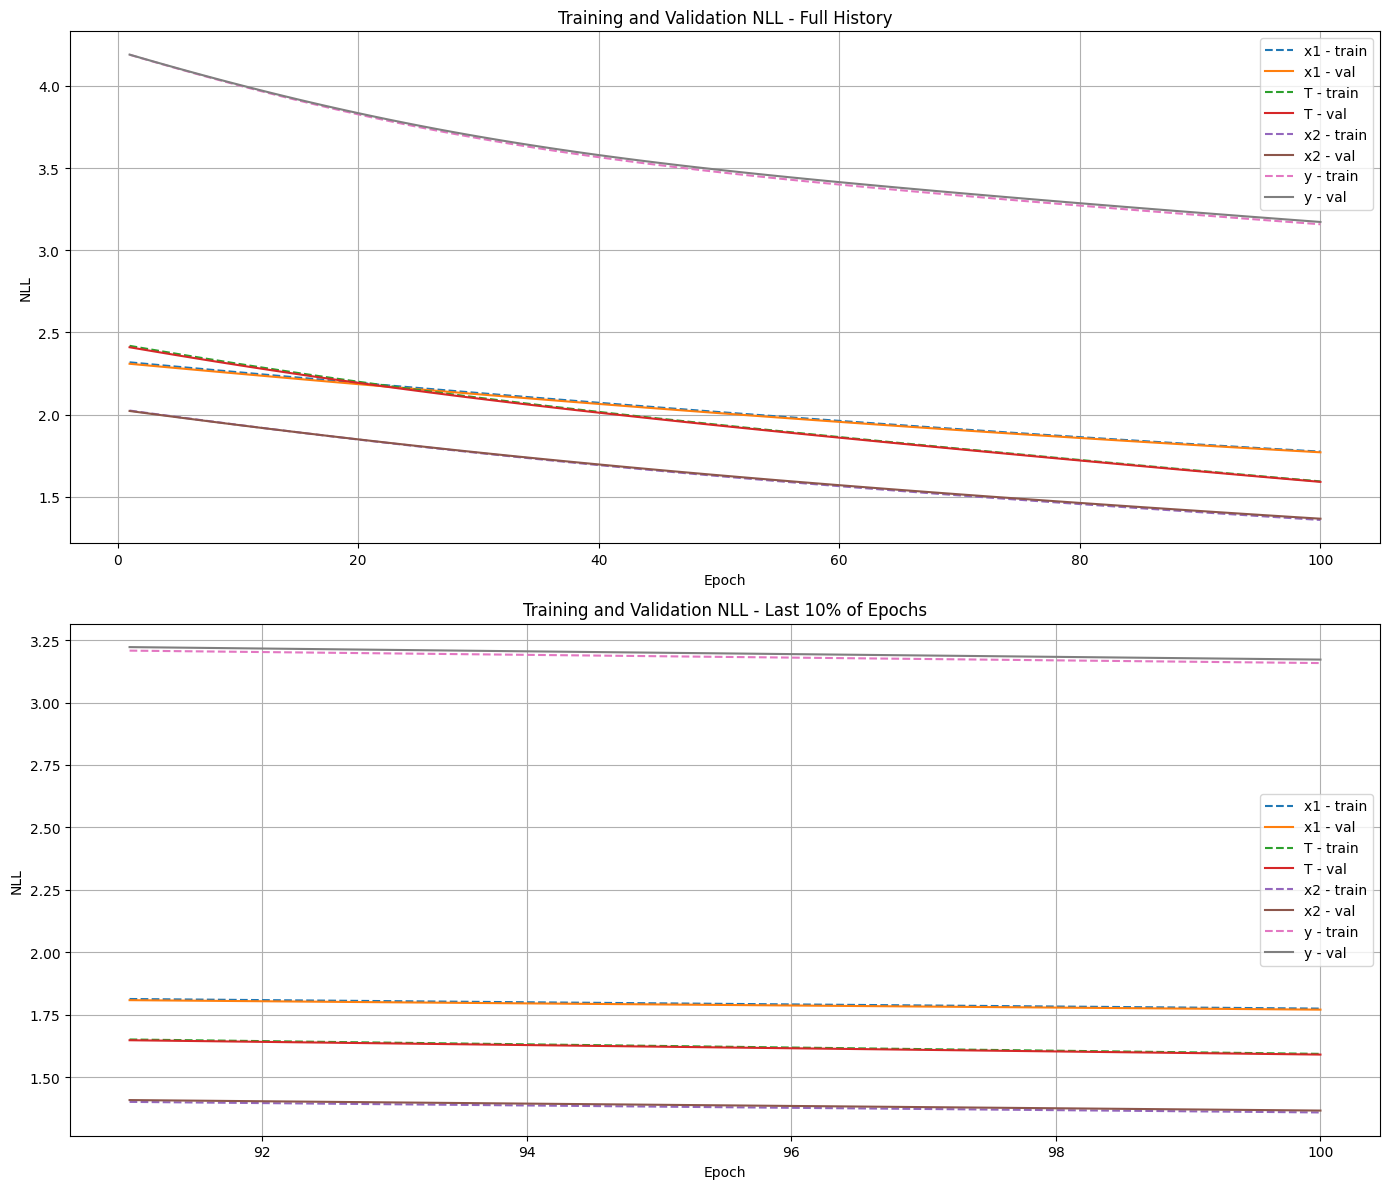

In [14]:
td_model.plot_loss_history()

In [ ]:
#td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x2':[-0.1815344, -1.0012274 ]})

In [ ]:
## td_model.linear_shift_history()

In [ ]:
#td_model.plot_simple_intercepts_history(ref_lines={'x1':[-1.998953,  0.426397,  1.032376]})

Directory does not exist: exp/x1/sampling
Directory does not exist: exp/T/sampling
Directory does not exist: exp/x2/sampling
Directory does not exist: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 276.09it/s]


----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[WARNING] target_col 'T' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 313.37it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 306.59it/s]


----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 297.02it/s]


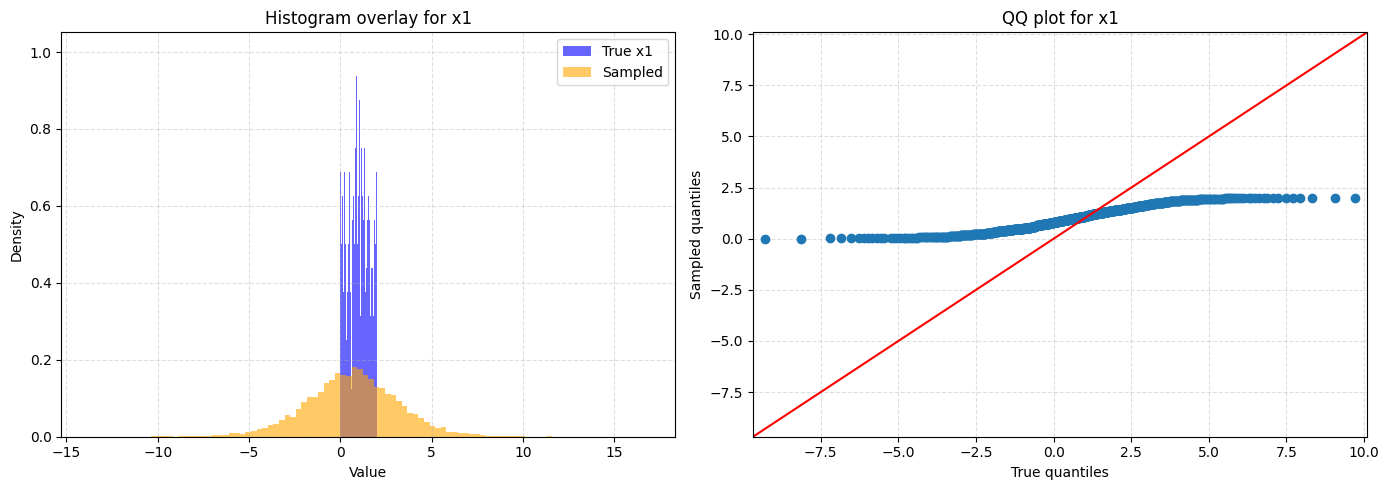

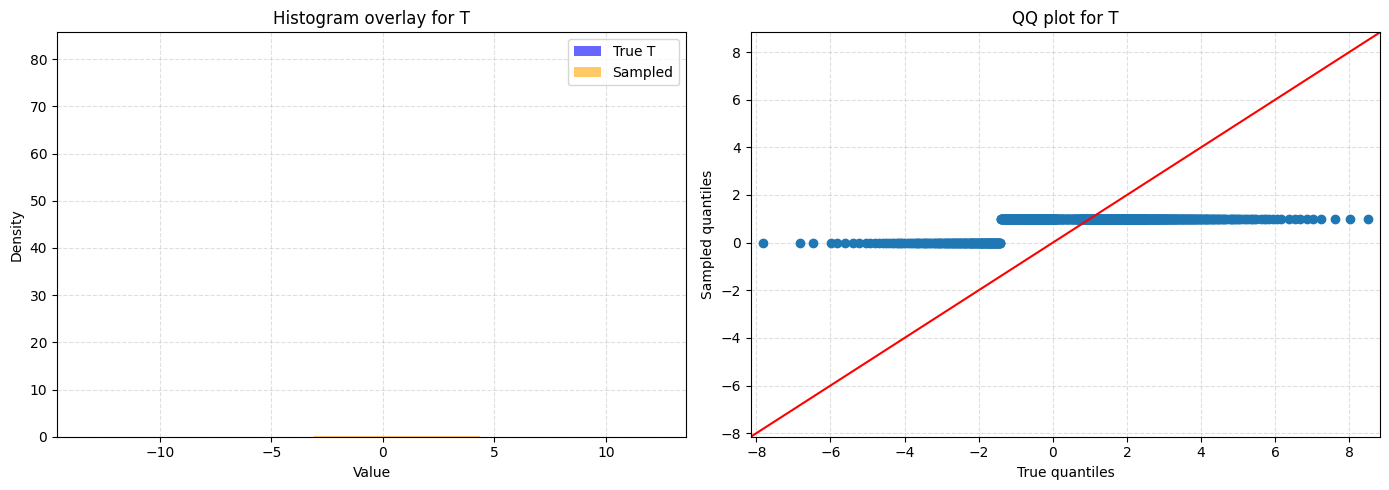

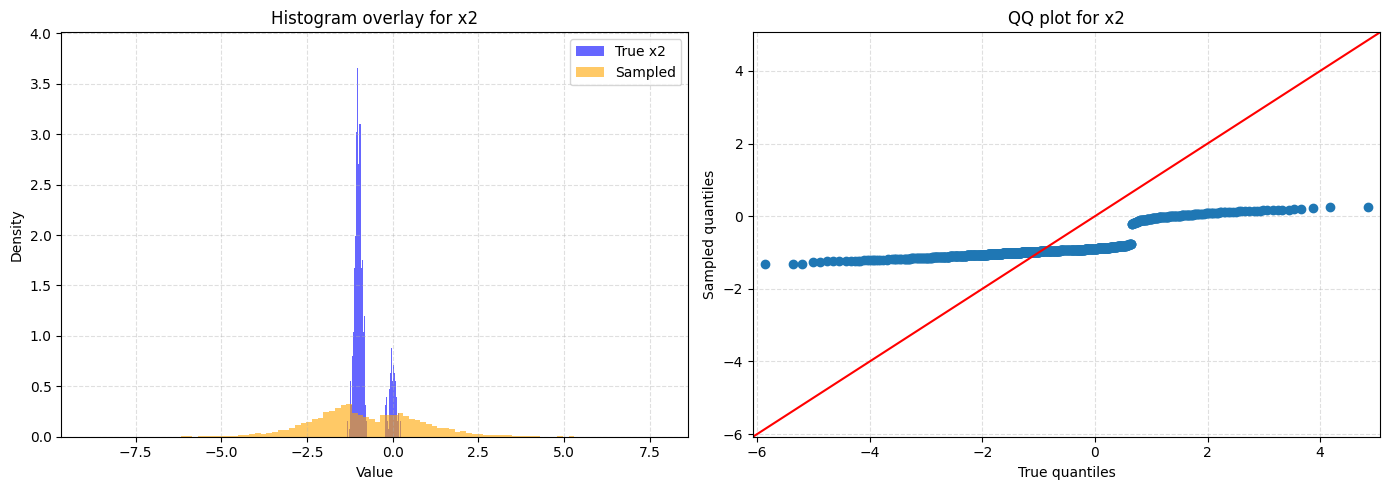

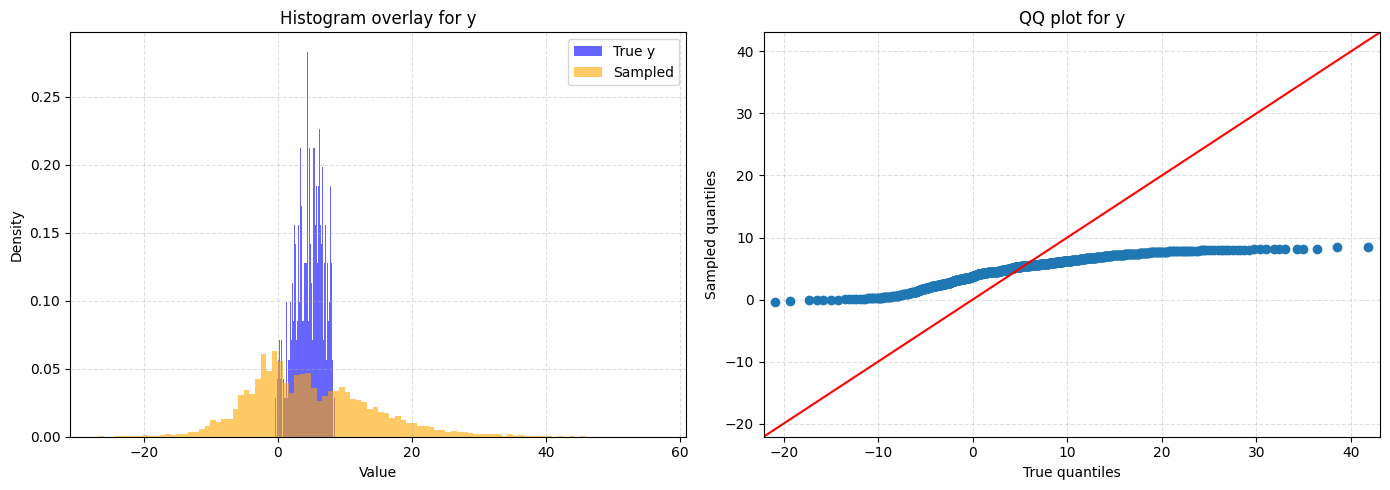

In [15]:
rsamples, latents = td_model.sample()
td_model.plot_samples_vs_true(train_df)

In [13]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp/min_max_scaling.json


In [ ]:
rsamples, latents = td_model.sample(do_interventions={'x1':-1.0})
inter_df=dgp(n_obs=10_000, doX=[-1.0,None , None])
td_model.plot_samples_vs_true(inter_df)

In [ ]:
u_training = td_model.get_latent(train_df)

In [ ]:
u_training.head()

In [ ]:
train_df.head()

In [25]:
# Make cross tab of T and x1
train_df['T']

29     1
535    0
695    1
557    1
836    1
      ..
106    1
270    1
860    1
435    0
102    1
Name: T, Length: 800, dtype: int64

In [14]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[INFO] Final latent DataFrame shape: (800, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Directory does not exist: exp/x1/sampling
Directory does not exist: exp/T/sampling
Directory does not exist: exp/x2/sampling
Directory does not exist: exp/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[WARNING] Best model not found for node 'x

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 340.79it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 347.44it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U
[WARNING] Best model not found for node 'y'. Using initial weights instead.
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 339.45it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


In [18]:
type(samples_doT1_with_T1)

pandas.core.frame.DataFrame

In [15]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

(800, 4)


0      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
794    1.0
795    1.0
796    1.0
798    1.0
799    1.0
Name: T, Length: 675, dtype: float32

In [ ]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


np.float64(1.0)

In [28]:
train_with_T1['T']

29     1
695    1
557    1
836    1
596    1
      ..
700    1
106    1
270    1
860    1
102    1
Name: T, Length: 653, dtype: int64

In [17]:
import matplotlib.pyplot as plt

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

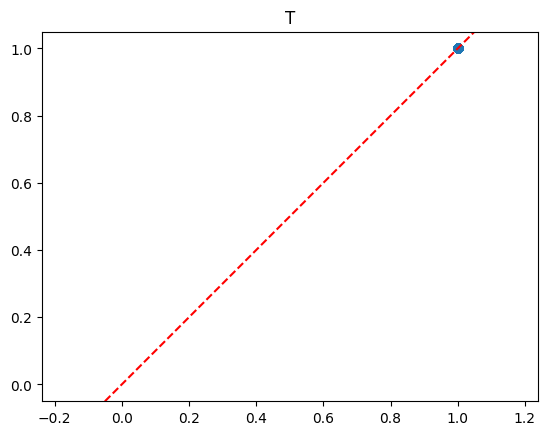

In [18]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

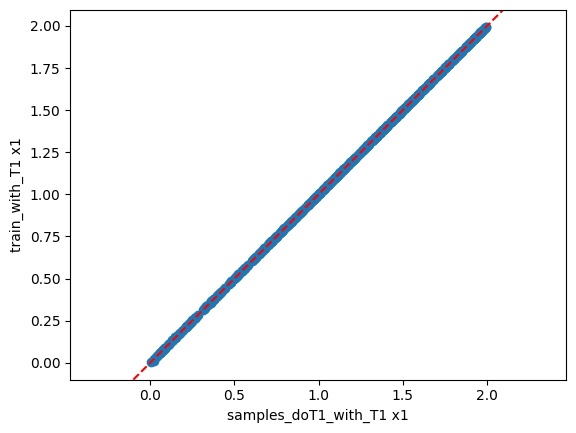

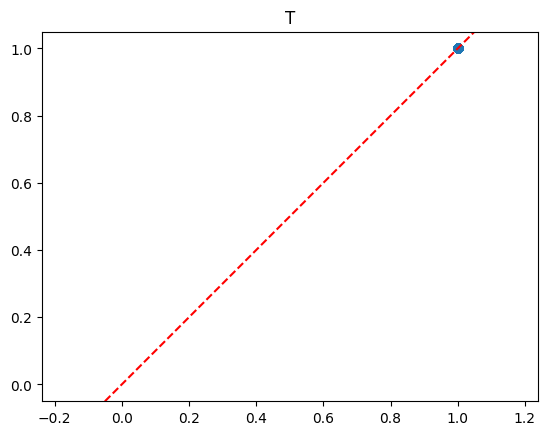

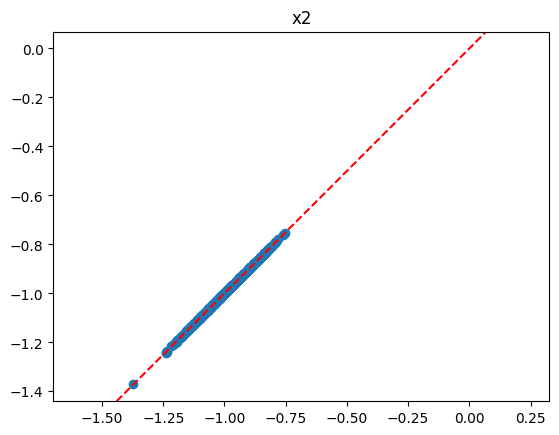

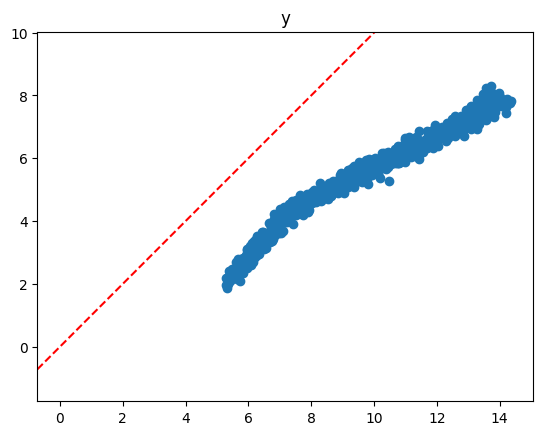

In [19]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()



In [ ]:
data_doT1